# Does mobility decrease cooperation?

以下は、下記論文の結果の一部を簡易的に再現したものです。

Vainstein, M. H., Silva, A. T., & Arenzon, J. J. (2007). Does mobility decrease cooperation?. Journal of theoretical biology, 244(4), 722-728. https://doi.org/10.1016/j.jtbi.2006.09.012

## Abstract

We explore the minimal conditions for sustainable cooperation on a spatially distributed population of memoryless, unconditional strategies (cooperators and defectors) in presence of unbiased, non-contingent mobility in the context of the Prisoner's Dilemma game. We find that cooperative behavior is not only possible but may even be enhanced by such an “always-move” rule, when compared with the strongly viscous (“never-move”) case. In addition, mobility also increases the capability of cooperation to emerge and invade a population of defectors, what may have a fundamental role in the problem of the onset of cooperation.

# The Model

In [3]:
println("Julia: $(VERSION)")

using Agents
using Random
using Statistics: mean
using CairoMakie
using Plots

using Test: @testset, @test

Julia: 1.10.2


## Agent

In [5]:
@enum Strategy C D

@agent struct Agent(GridAgent{2})
    strategy::Strategy
    payoff::Float64

    Agent(id::Int, pos::Dims{2}, strategy::Strategy) = new(id, pos, strategy, 0.0)
    Agent(id::Int, pos::Dims{2}) = Agent(id, pos, D)
end

agent_color(agent::Agent)::Symbol = agent.strategy == C ? :blue : :red

function Base.show(io::IO, agent::Agent)::Nothing
    print(io, "id: $(agent.id), pos: $(agent.pos), strategy: $(agent.strategy), payoff: $(agent.payoff)")
end;

In [6]:
@testset "Agent and agent_color" begin
    agent = Agent(1, (1, 1))
    @test agent.id == 1
    @test agent.pos == (1, 1)
    @test agent.strategy == D
    @test agent.payoff == 0.0
    agent_color(agent) == :red
    
    agent.strategy = C
    agent_color(agent) == :blue
    
    agent.payoff = 9.9
    @test agent.payoff == 9.9

    @test "$(agent)" == "id: 1, pos: (1, 1), strategy: C, payoff: 9.9"
end;

Test Summary:         | Pass  Total  Time
Agent and agent_color |    6      6  0.2s


## Game

In [8]:
# Payoff Table (weak PD)
const PAYOFFS = (
    R = 1.0,  # CC
    T = 1.4,  # DC
    S = 0.0,  # CD
    P = 0.0   # DD
)

function play_game!(agent1::Agent, agent2::Agent)::Nothing
    strategy_pair = agent1.strategy, agent2.strategy
    
    payoff1, payoff2 = if strategy_pair == (C, C)
        PAYOFFS.R, PAYOFFS.R
    elseif strategy_pair == (D, C)
        PAYOFFS.T, PAYOFFS.S
    elseif strategy_pair == (C, D)
        PAYOFFS.S, PAYOFFS.T
    elseif strategy_pair == (D, D)
        PAYOFFS.P, PAYOFFS.P
    else
        error("Something wrong...")
    end

    agent1.payoff += payoff1
    agent2.payoff += payoff2

    return
end;

In [9]:
@testset "play_game!" begin
    agent1 = Agent(1, (1, 1), C)
    agent2 = Agent(2, (2, 2), C)

    play_game!(agent1, agent2)
    @test agent1.payoff == PAYOFFS.R
    @test agent2.payoff == PAYOFFS.R

    agent3 = Agent(3, (3, 3), D)
    play_game!(agent2, agent3)
    @test agent2.payoff == PAYOFFS.R + PAYOFFS.S
    @test agent3.payoff == PAYOFFS.T

    agent4 = Agent(4, (4, 4), D)
    play_game!(agent3, agent4)
    @test agent3.payoff == PAYOFFS.T + PAYOFFS.P
    @test agent4.payoff == PAYOFFS.P

    play_game!(agent4, agent1)
    @test agent4.payoff == PAYOFFS.P + PAYOFFS.T
    @test agent1.payoff == PAYOFFS.R + PAYOFFS.S
end;

Test Summary: | Pass  Total  Time
play_game!    |    8      8  0.0s


## Model

In [11]:
function initialize_model(; dims::Dims{2} = (100, 100), n::Int, nC::Int, diffusion_prob::Float64, dynamics::Symbol)::ABM
    properties = (
        diffusion_prob = diffusion_prob,
        c_rate_vec = [nC / n],
        dynamics = dynamics,
    )

    space = GridSpace(dims; periodic = true, metric = :manhattan)  # Von Neumann neighborhood (4 neighbors)
    model = StandardABM(Agent, space, model_step! = run_one_generation!; properties)

    for _ in 1:nC
        add_agent!(Agent, model, C)
    end

    for _ in 1:(n - nC)
        add_agent!(Agent, model, D)
    end

    return model
end

c_rate(model::ABM)::Float64 = mean([agent.strategy == C for agent in allagents(model)]);

In [12]:
function combat(model::ABM)::Nothing
    # Each individual combats with all its four closest neighbors (if any), accumulates the corresponding payoff
    played_pairs = Set{Tuple{Int, Int}}()
    for agent in allagents(model)
        for neighboring_agent in nearby_agents(agent, model)
            pair = (min(agent.id, neighboring_agent.id), max(agent.id, neighboring_agent.id))

            if !(pair in played_pairs)
                play_game!(agent, neighboring_agent)
                push!(played_pairs, pair)
            end
        end
    end

    return
end

function diffusion(model::ABM)::Nothing
    # each agent makes an attempt to jump to a site chosen randomly within its four nearest neighbors,
    # what is accepted, provided the site is empty, with a probability m.
    # CDO (combat–diffusion–offspring) dynamics
    for agent in allagents(model)
        target_pos = random_nearby_position(agent, model)

        if isempty(agents_in_position(target_pos, model)) && rand() < model.diffusion_prob
            move_agent!(agent, target_pos, model)
        end
    end

    return
end

function offspring(model::ABM)::Nothing
    # each player compares its total payoff with the ones of its neighbors and changes strategy,
    # following the one with the greatest payoff among them.
    agent_strategy_dict = Dict{Int, Strategy}()

    for agent in allagents(model)
        max_neighboring_agent = reduce(
            (a, b) -> a.payoff > b.payoff ? a : b,
            nearby_agents(agent, model),
            init = agent
        )
        agent_strategy_dict[agent.id] = max_neighboring_agent.strategy
    end

    for agent in allagents(model)
        agent.strategy = agent_strategy_dict[agent.id]
        agent.payoff = 0.0
    end

    return
end

function display_grid(model::ABM)::Nothing
    generation = length(model.c_rate_vec) - 1

    generation ∉ [1, 5, 10, 100, 1000] && return

    plotkwargs = (;
        agent_color = agent_color,
        agent_size = 5,
        agent_marker = :rect,
    )

    fig, ax, _ = abmplot(model; plotkwargs...)

    ax.title = "$(model.dynamics), m: $(model.diffusion_prob), Generation: $(generation)"
    ax.xticksvisible = false  # x軸の目盛りを非表示
    ax.yticksvisible = false  # y軸の目盛りを非表示
    ax.xticklabelsvisible = false  # x軸目盛りのラベルを非表示
    ax.yticklabelsvisible = false  # y軸目盛りのラベルを非表示

    # display(fig)
    # savefig("Fig3_$(model.dynamics)_m:$(model.diffusion_prob)_Gen:$(generation).png");
    save("grid_img/Fig3_$(model.dynamics)_m:$(model.diffusion_prob)_Gen:$(generation).png", fig)

    return
end

function run_one_generation!(model::ABM)::Nothing
    combat(model)

    if model.dynamics == :CDO
        diffusion(model)
        offspring(model)
    else
        offspring(model)
        diffusion(model)
    end
    
    push!(model.c_rate_vec, c_rate(model))
    display_grid(model)

    return
end;

In [13]:
@testset "Model" begin
    model = initialize_model(n = 7000, nC = 2800, diffusion_prob = 0.1, dynamics = :CDO)
    @show model

    @test nagents(model) == 7000
    @test c_rate(model) == 0.4
end;

model = StandardABM with 7000 agents of type Agent
 agents container: Dict
 space: GridSpace with size (100, 100), metric=manhattan, periodic=true
 scheduler: fastest
 properties: diffusion_prob, c_rate_vec, dynamics
Test Summary: | Pass  Total  Time
Model         |    2      2  0.1s


In [14]:
default(
    fontfamily="Arial",
    titlefontsize=16,
    guidefontsize=14,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
    dpi=600,
)

function plot_line!(model::ABM)::Plots.Plot
    xticks = [1, 10, 100, 1_000, 10_000]
    return Plots.plot!(
        model.c_rate_vec,
        xlabel = "Generation (Log Scale)",
        xscale = :log10,
        xticks = (xticks, string.(xticks)),
        ylabel = "Frequency of C",
        ylim = (-0.01, 1.01),
        yticks = 0:0.1:1,
        label = "m = $(model.diffusion_prob)",
        lw = 2,
    )
end;

# Result

## Figs. 1

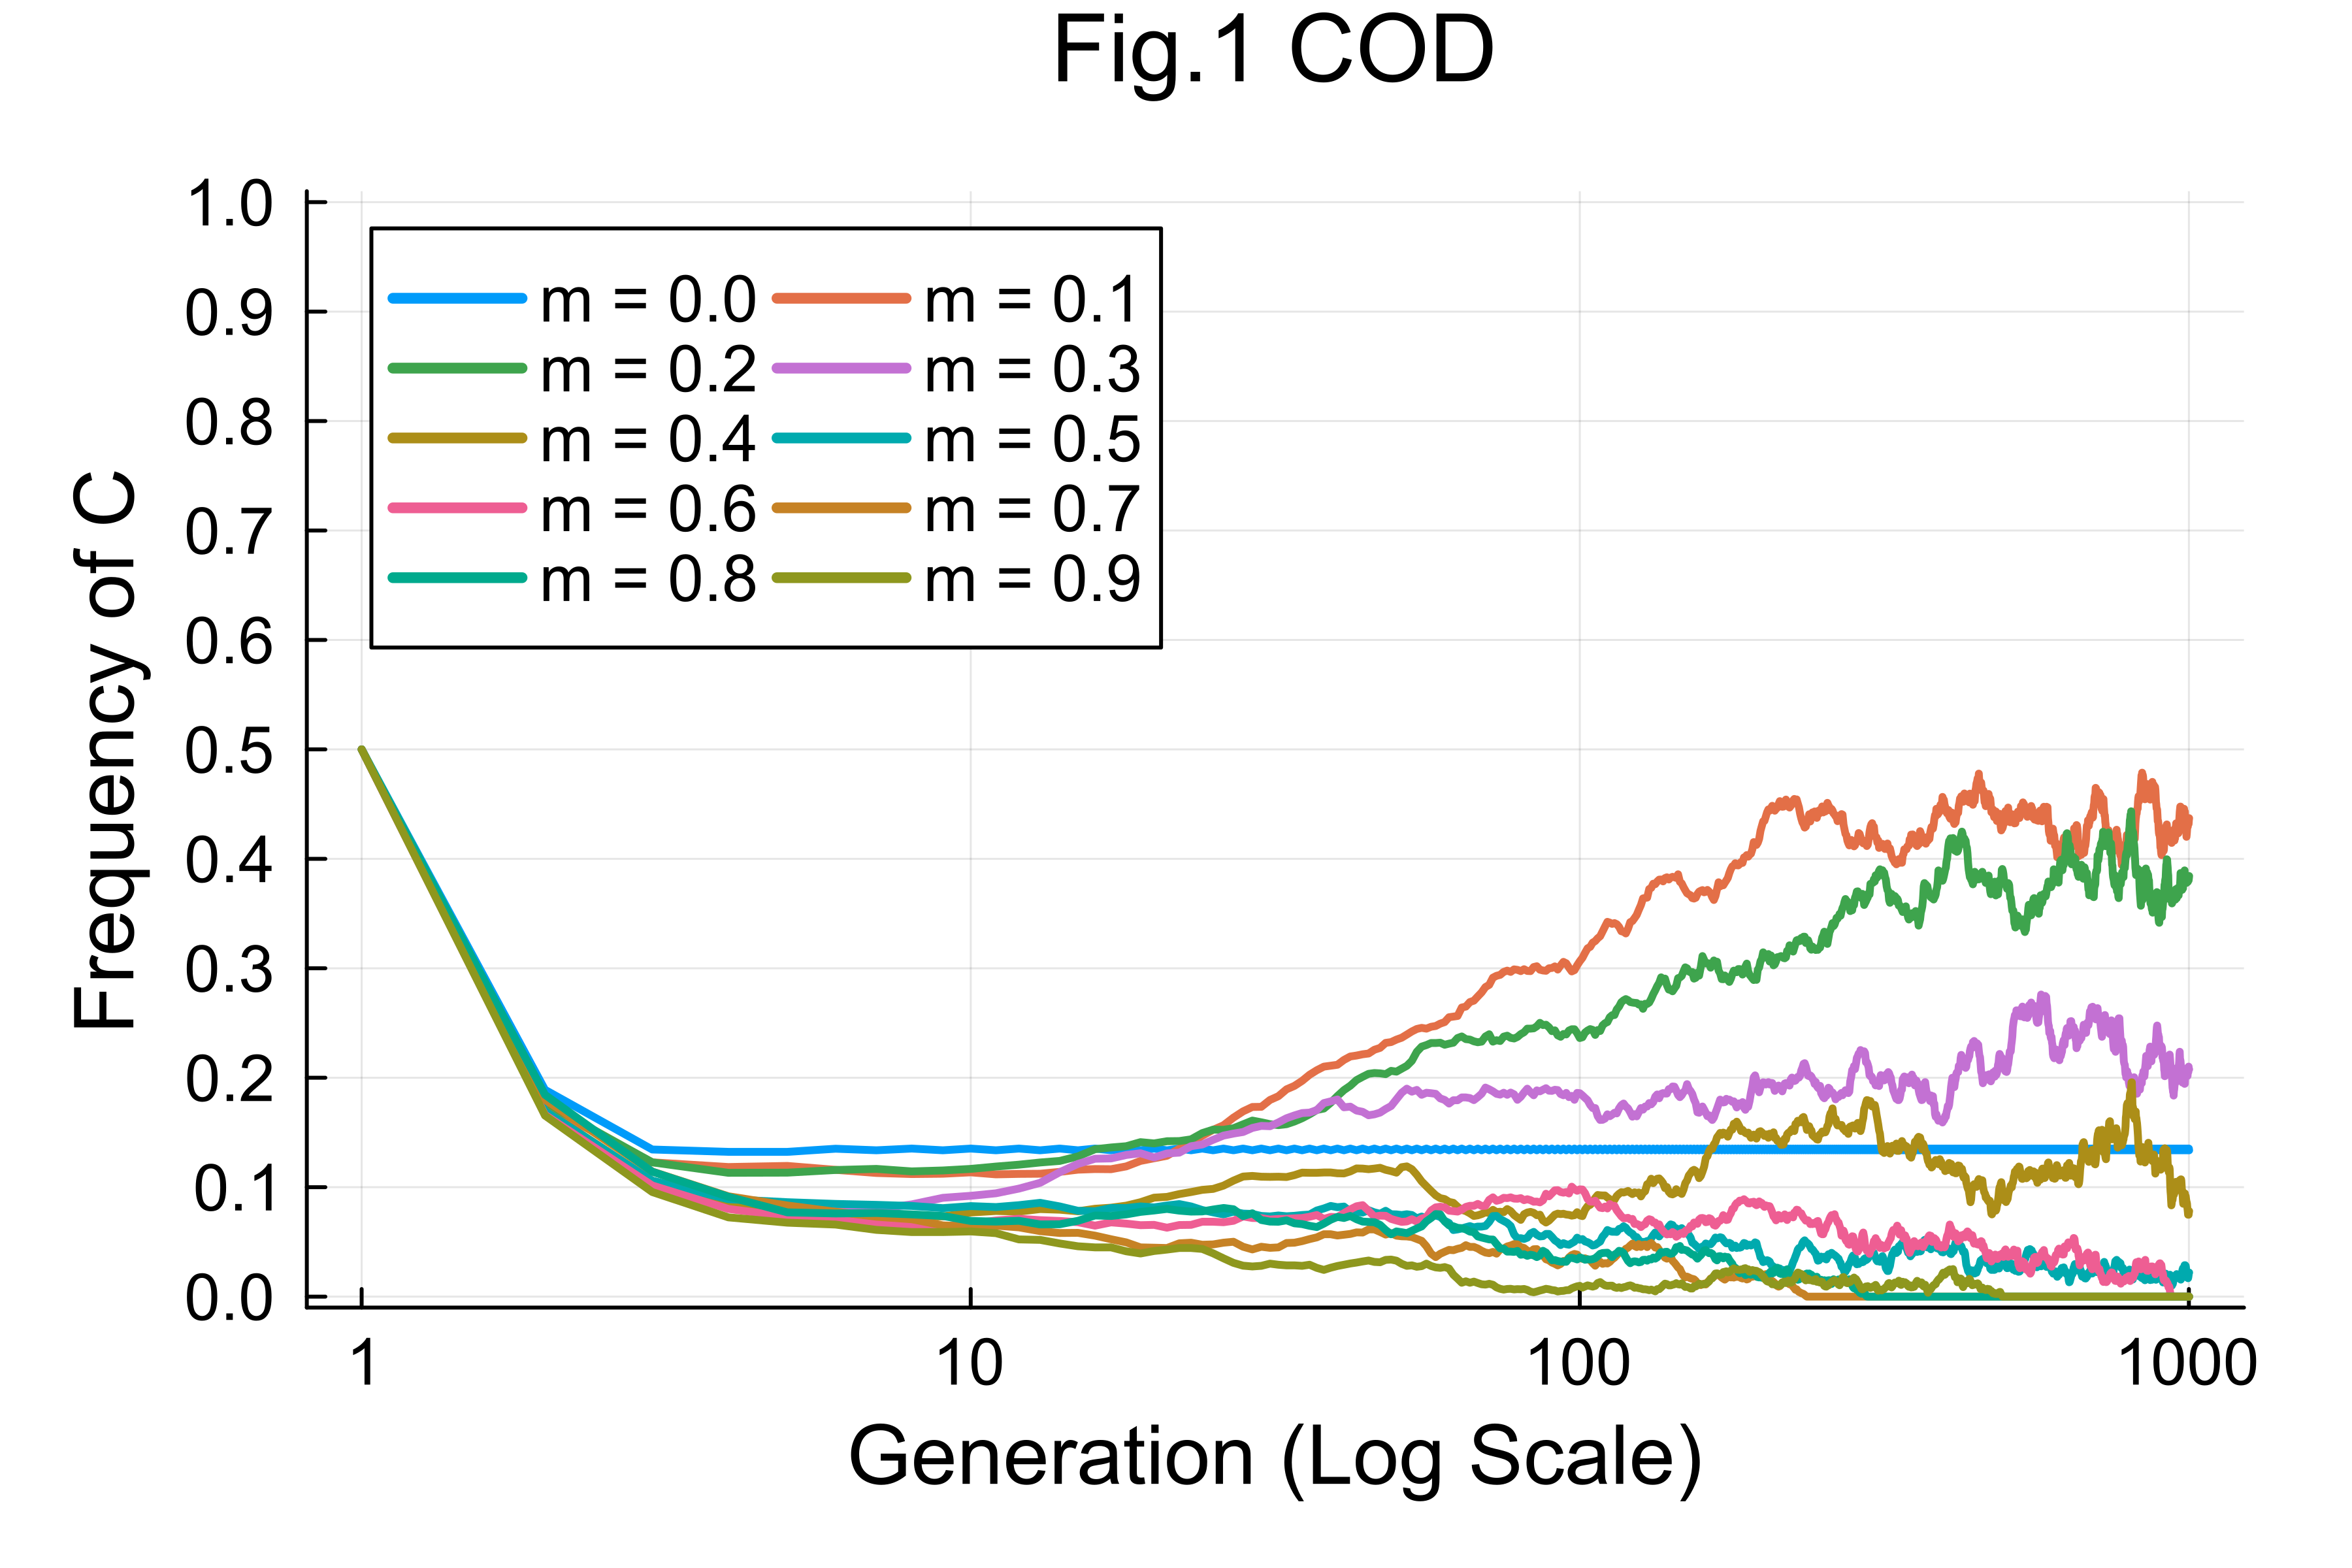

In [33]:
p = Plots.plot(title = "Fig.1 COD", legend = :topleft, legend_columns = 2)
steps = 1_000

for diffusion_prob in 0.0:0.1:0.9
    model = initialize_model(n = 7000, nC = 3500, diffusion_prob = diffusion_prob, dynamics = :COD)
    run!(model, steps)
    plot_line!(model)
end

display(p)
savefig("Fig3a.png");

## Fig. 2

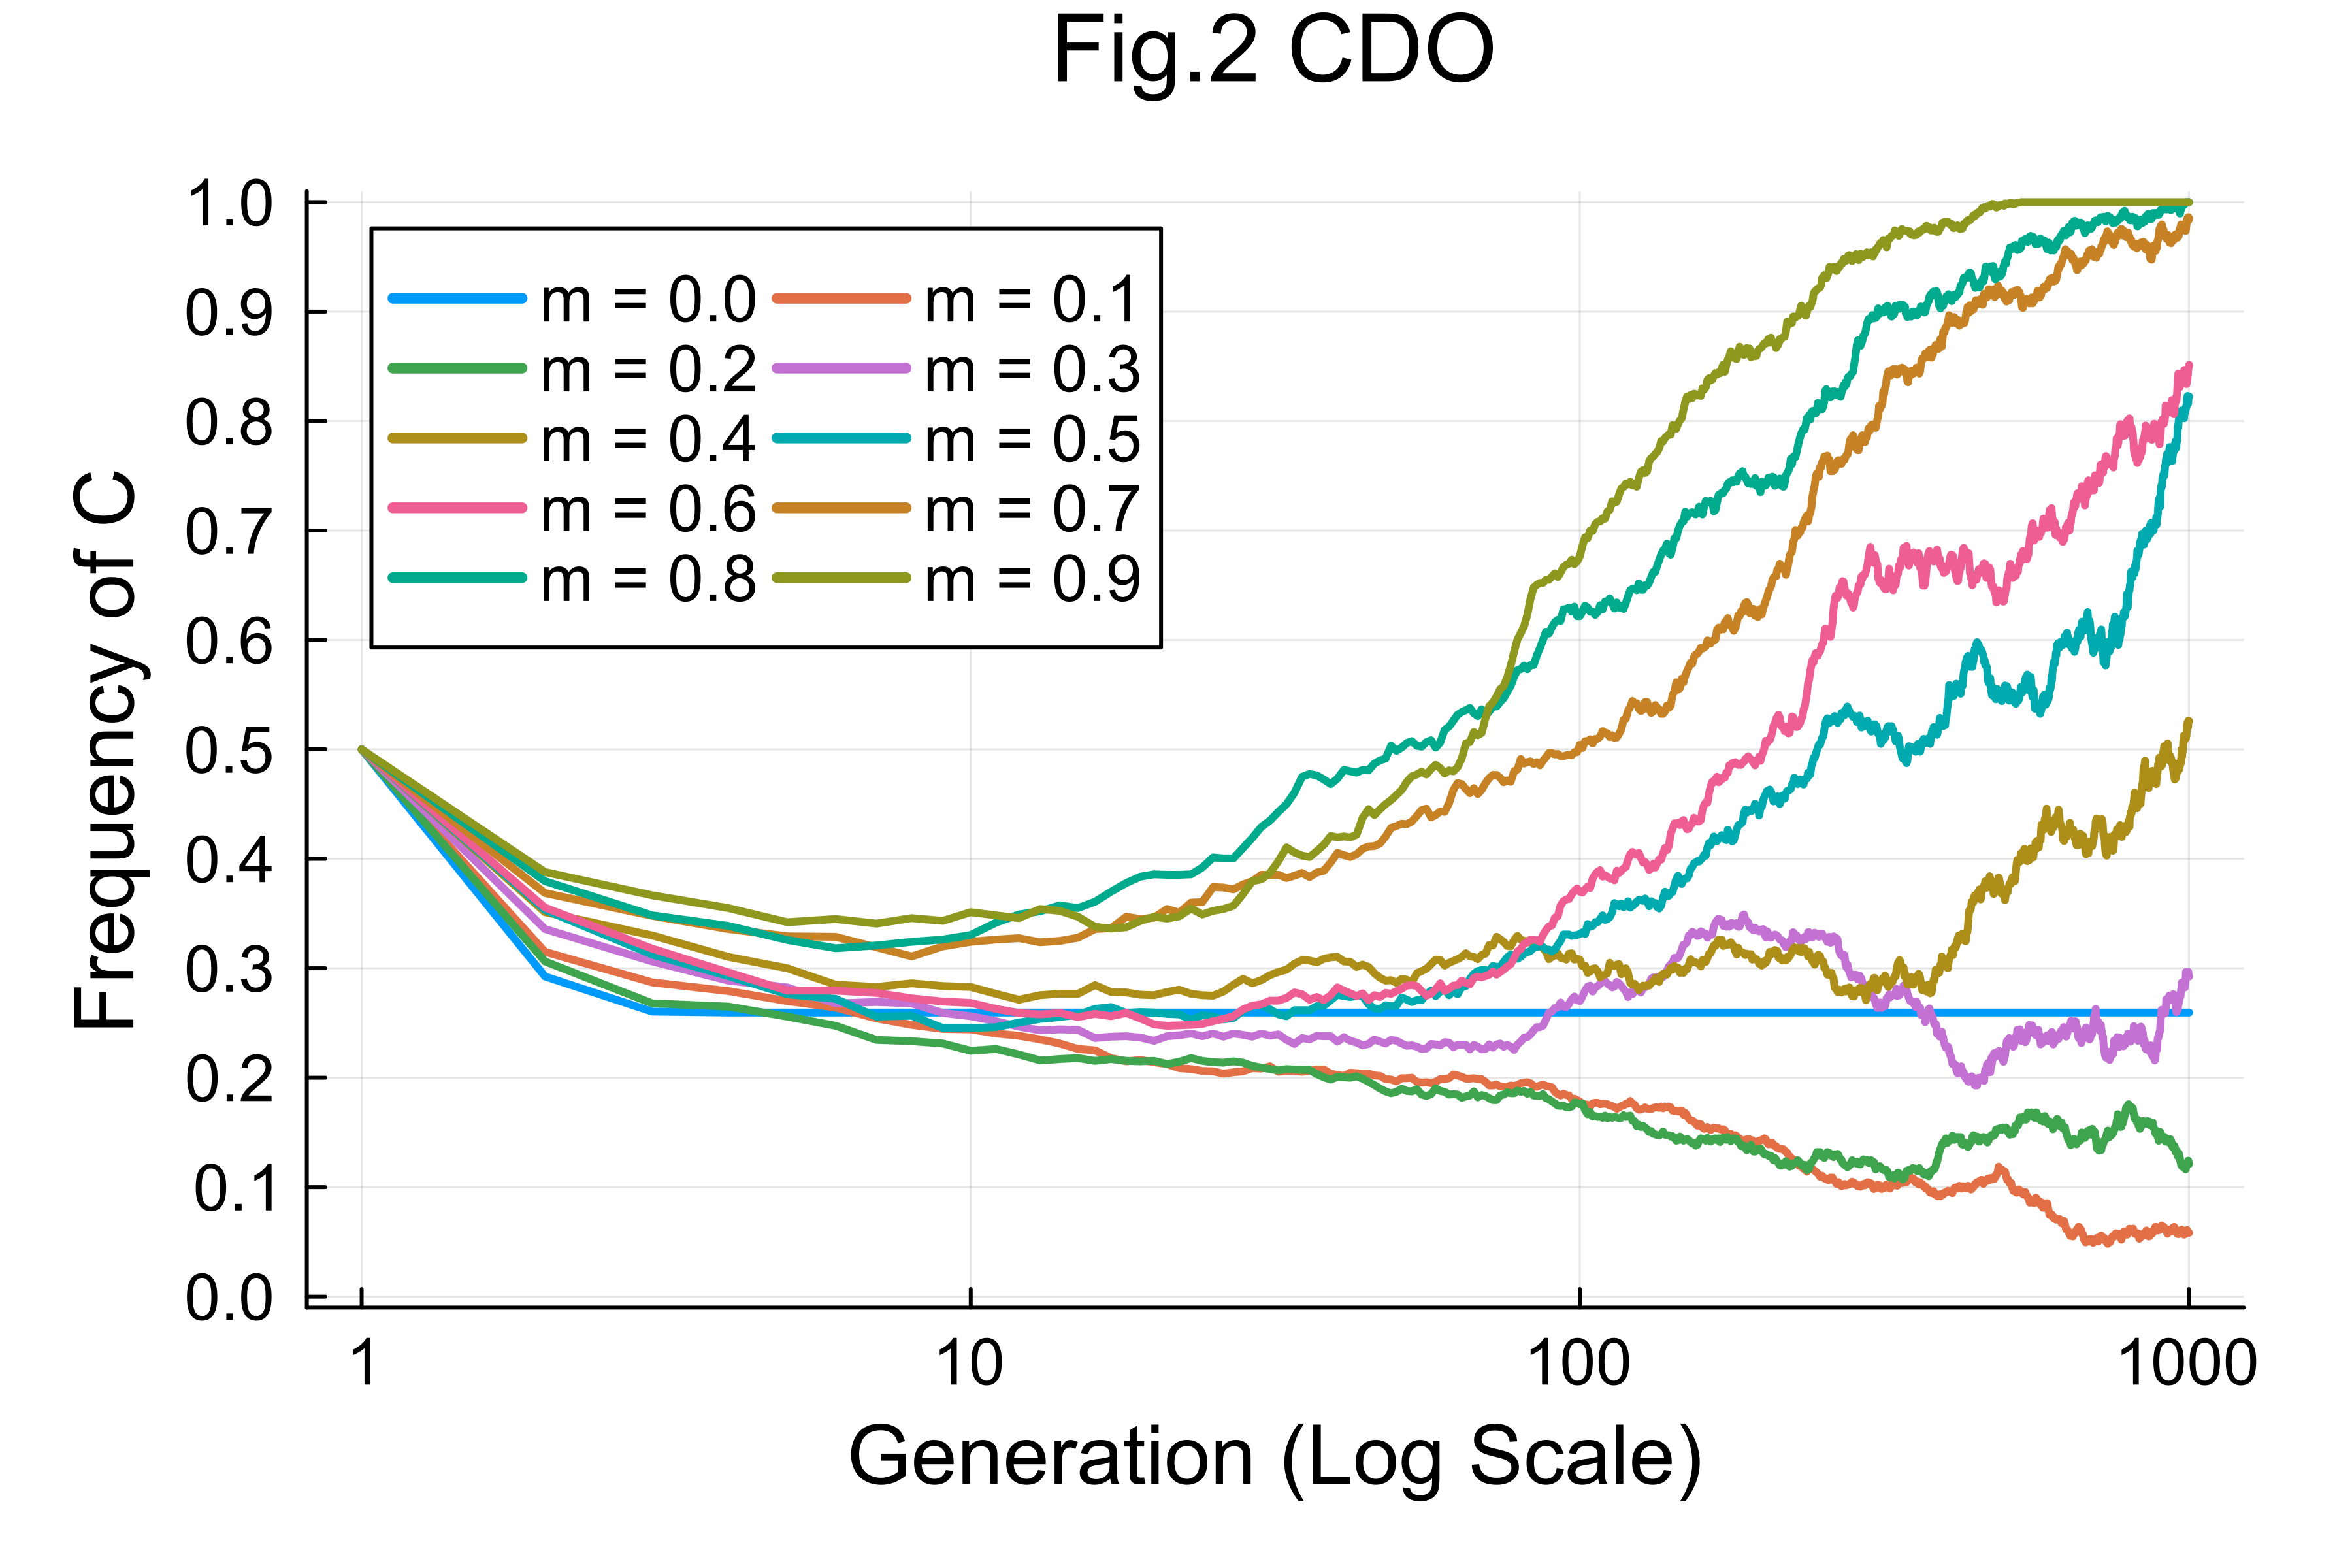

In [35]:
p = Plots.plot(title = "Fig.2 CDO", legend = :topleft, legend_columns = 2)
steps = 1_000

for diffusion_prob in 0.0:0.1:0.9
    model = initialize_model(n = 2400, nC = 1200, diffusion_prob = diffusion_prob, dynamics = :CDO)
    run!(model, steps)
    plot_line!(model)
end

display(p)
savefig("Fig3b.png");